In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.stats import norm
from ploting import *
import seaborn as sns
%matplotlib inline

import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
torch.manual_seed(123)

## Create data

In [2]:
def generate_data(sampleSize=1000):
    
    x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, sampleSize))).T
    r_data = np.float32(np.random.normal(size=(sampleSize,1)))
    y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)
    
    return train_test_split(x_data, y_data, random_state=42)

In [3]:
X_train, X_test, y_train, y_test = generate_data()

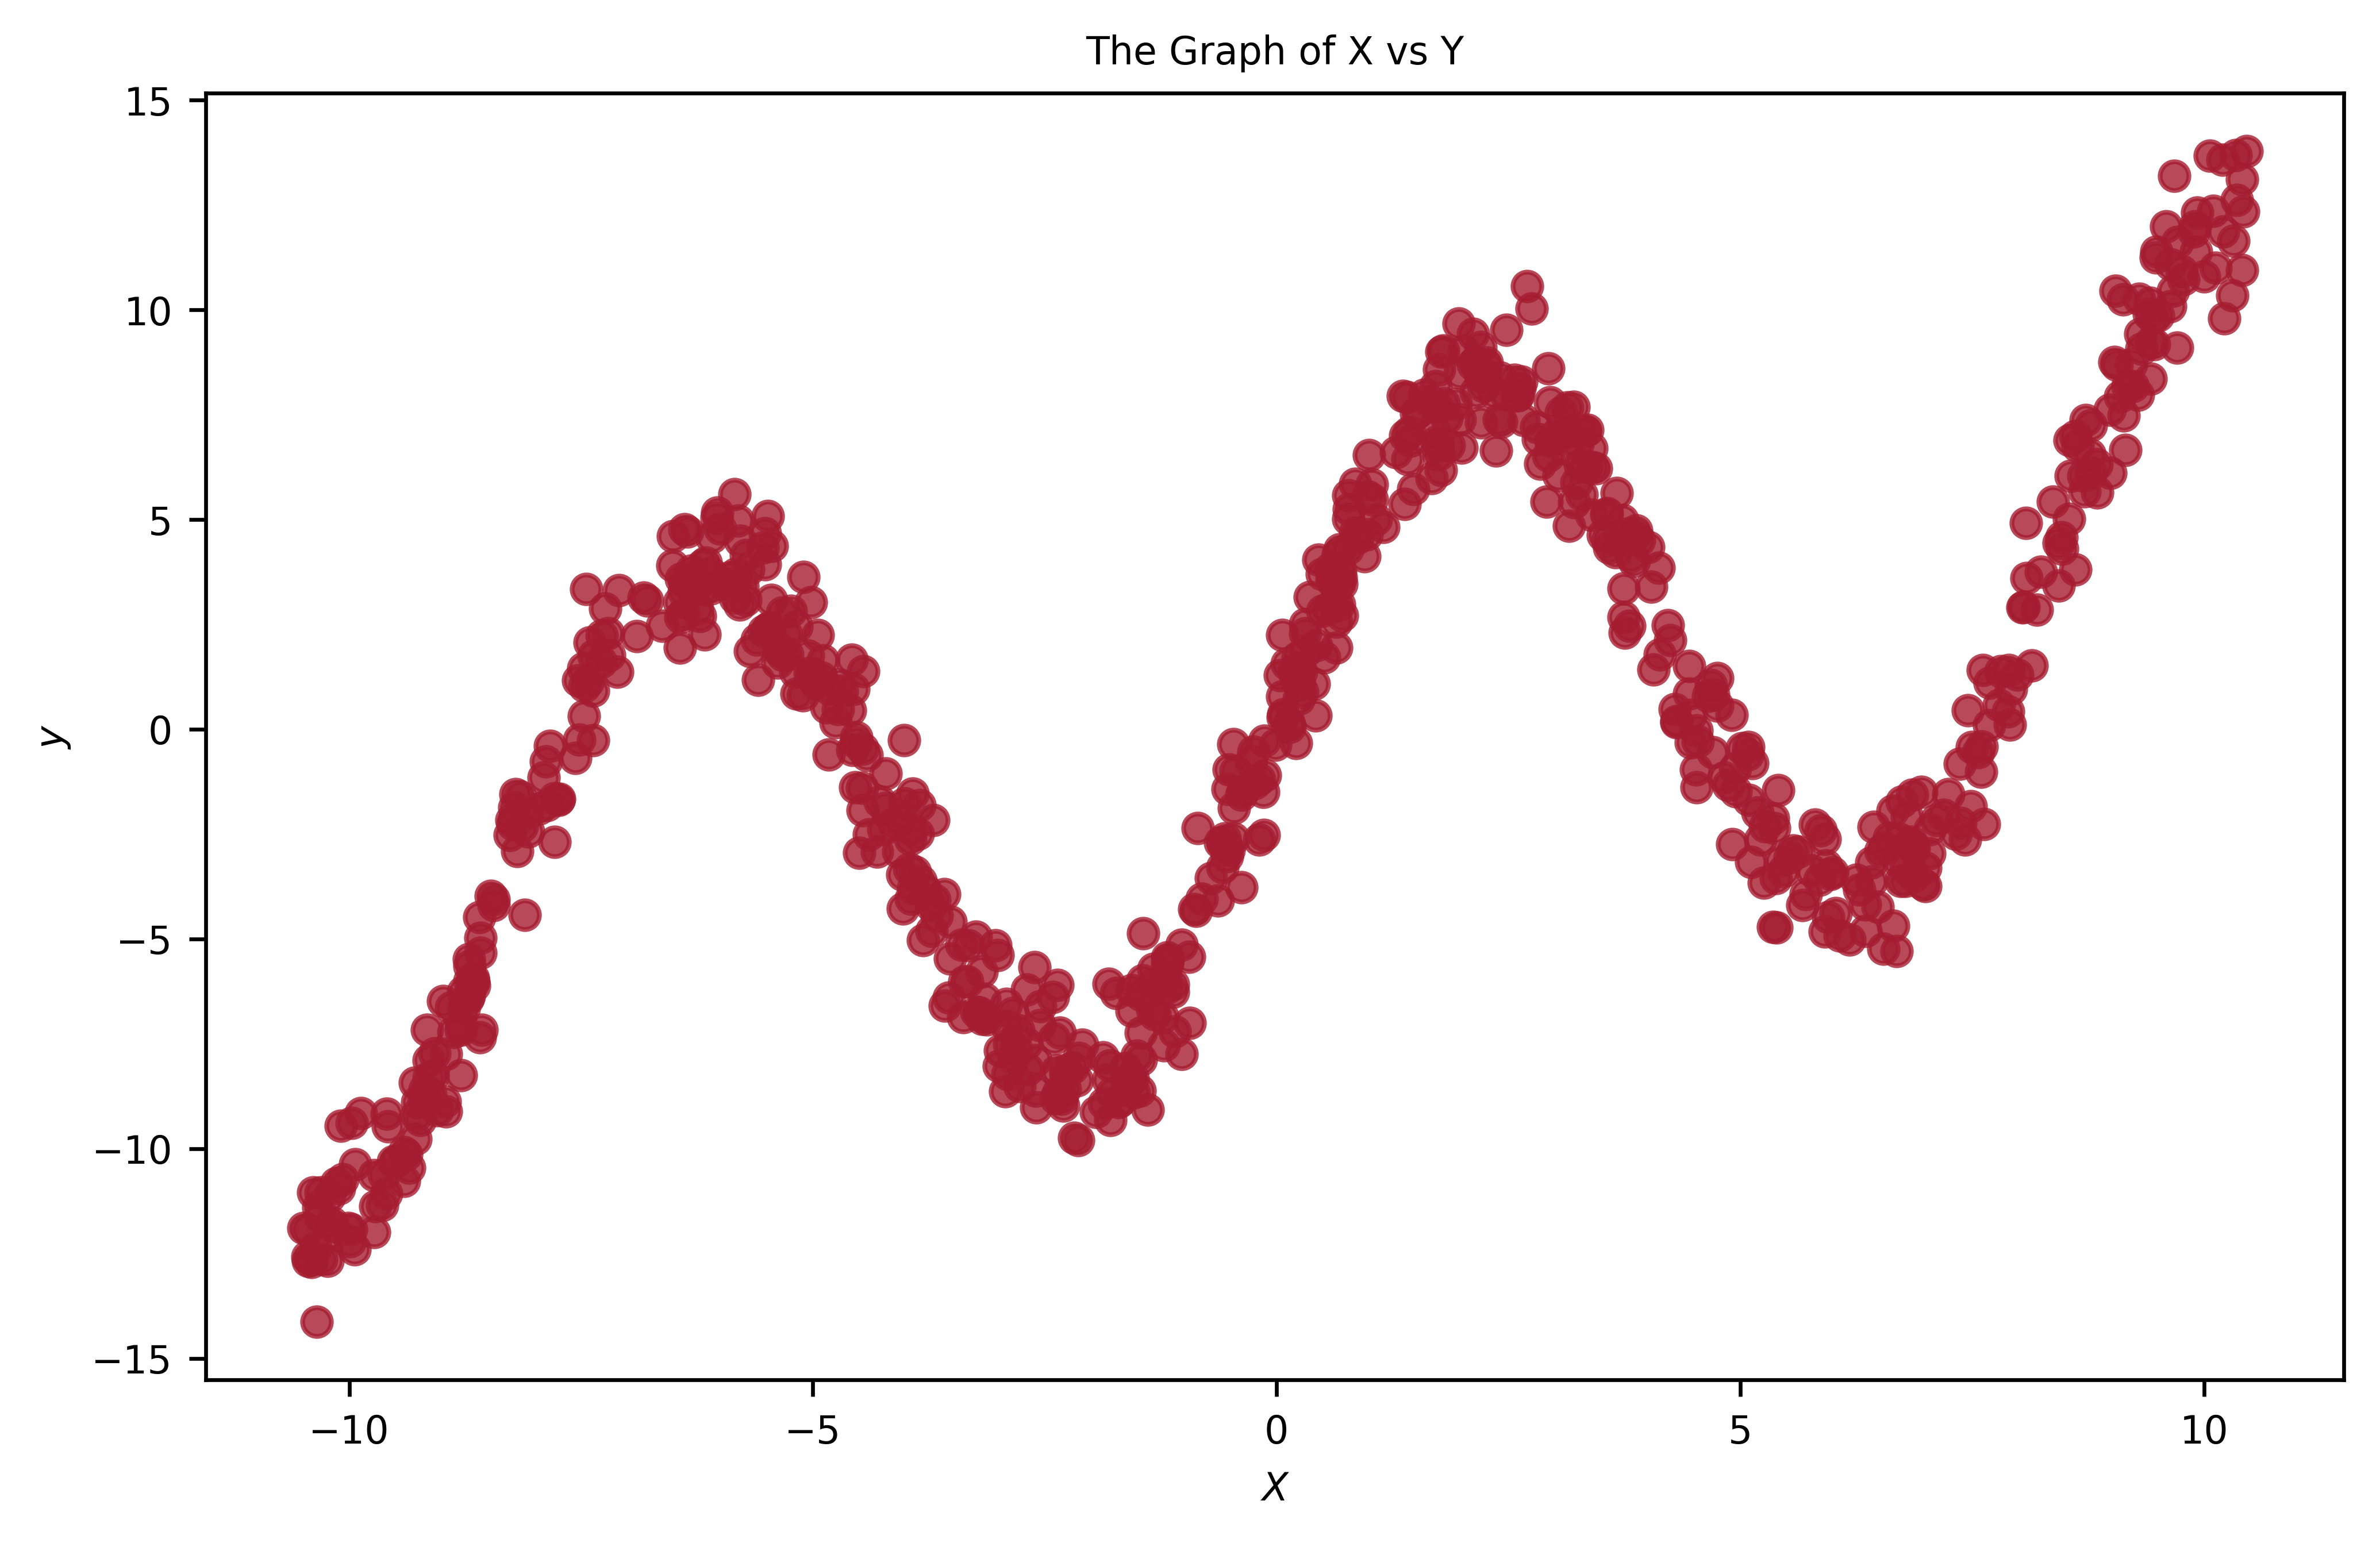

In [4]:
latexify(fig_width=8)
sns.regplot(X_train, y_train, fit_reg=False)
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.title("The Graph of X vs Y");

## Define MDN

In [5]:
class MDN(torch.nn.Module):

    def __init__(self, hidden_size, num_mixtures):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(MDN, self).__init__()
        self.input_layer = torch.nn.Linear(1, hidden_size) 
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.pi_out = torch.nn.Sequential(torch.nn.Linear(hidden_size, num_mixtures),torch.nn.Softmax())
        self.sigma_out = torch.nn.Linear(hidden_size, num_mixtures)
        self.mu_out = torch.nn.Linear(hidden_size, num_mixtures) 
        

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        
        out = self.input_layer(x)
        out = self.tanh(out)
        out_pi = self.pi_out(out)
        out_sigma = torch.exp(self.sigma_out(out))
        out_mu = self.mu_out(out)
        
        return (out_pi, out_sigma, out_mu)

## Define Loss function

In [6]:
def gaussian_distribution(y, mu, sigma):
    
    oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = - 0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI


def mdn_loss_function(out_pi, out_sigma, out_mu, y):
    
    result = gaussian_distribution(y, out_mu, out_sigma) * out_pi
    result = torch.sum(result, dim=1)
    result = - torch.log(result)
    
    return torch.mean(result)

## Define train function

In [7]:
def model_train(x_data, y_data, model, lrate):
    
    x_data = torch.from_numpy(x_data).float()
    y_data = torch.from_numpy(y_data).float()
    
    x_data = Variable(x_data)
    y_data = Variable(y_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        y_data = y_data.cuda()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)
    
    
    Epoch = []
    Loss  = []
   
    
    for epoch in range(10000):
        (out_pi, out_sigma, out_mu) = model(x_data)
        loss = mdn_loss_function(out_pi, out_sigma, out_mu, y_data)

        Epoch.append(epoch)
        Loss.append(loss.data[0])
        
        if (epoch % 500 == 0):
            print(epoch, loss.data[0])
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    return Epoch, Loss 

## Define prediction

In [8]:
def predict(x_data, model):
    x_data = torch.from_numpy(x_data).float()
    x_data = Variable(x_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        
    (out_pi, out_sigma, out_mu) = model(x_data)
    
    if torch.cuda.is_available():
        out_pi=out_pi.cpu() # convert cuda tenso into cpu so that we can con
        out_sigma=out_sigma.cpu()
        out_mu = out_mu.cpu()
        
         
    return (out_pi.data.numpy(), out_sigma.data.numpy(), out_mu.data.numpy())

In [9]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1


def generate_ensemble(x_test, out_pi, out_sigma, out_mu, M=1):
    # for each point in X, generate M=10 ensembles
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0
    
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

In [10]:
def results(X_test, y_test):
    pi, sigma, mu = predict(X_test, model)
    y_pred = generate_ensemble(X_test, pi, sigma, mu)
    mse = MSE(y_test, y_pred)
    
    return y_pred, mse

## Run an experiment

In [11]:
model = MDN(hidden_size=5, num_mixtures=20)
print(model)

MDN(
  (input_layer): Linear(in_features=1, out_features=5)
  (relu): ReLU()
  (tanh): Tanh()
  (pi_out): Sequential(
    (0): Linear(in_features=5, out_features=20)
    (1): Softmax()
  )
  (sigma_out): Linear(in_features=5, out_features=20)
  (mu_out): Linear(in_features=5, out_features=20)
)


In [12]:
epoch, loss = model_train(X_train, y_train, model, 0.01)

0 6.282874584197998
500 2.2256648540496826
1000 1.802548885345459
1500 1.6754703521728516
2000 1.6544933319091797
2500 1.5711432695388794
3000 1.4932643175125122
3500 1.4459455013275146
4000 1.4135398864746094
4500 1.3936419486999512
5000 1.3717516660690308
5500 1.366523265838623
6000 1.3609631061553955
6500 1.3596960306167603
7000 1.3751373291015625
7500 1.3884915113449097
8000 1.3690919876098633
8500 1.3786813020706177
9000 1.3756531476974487
9500 1.374105453491211


In [ ]:
plt.plot(epoch, loss, label="$lrate=0.1$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs iterations")
plt.legend();

## Get results

In [13]:
y_pred_mdn, mse_mdn=results(X_test, y_test)

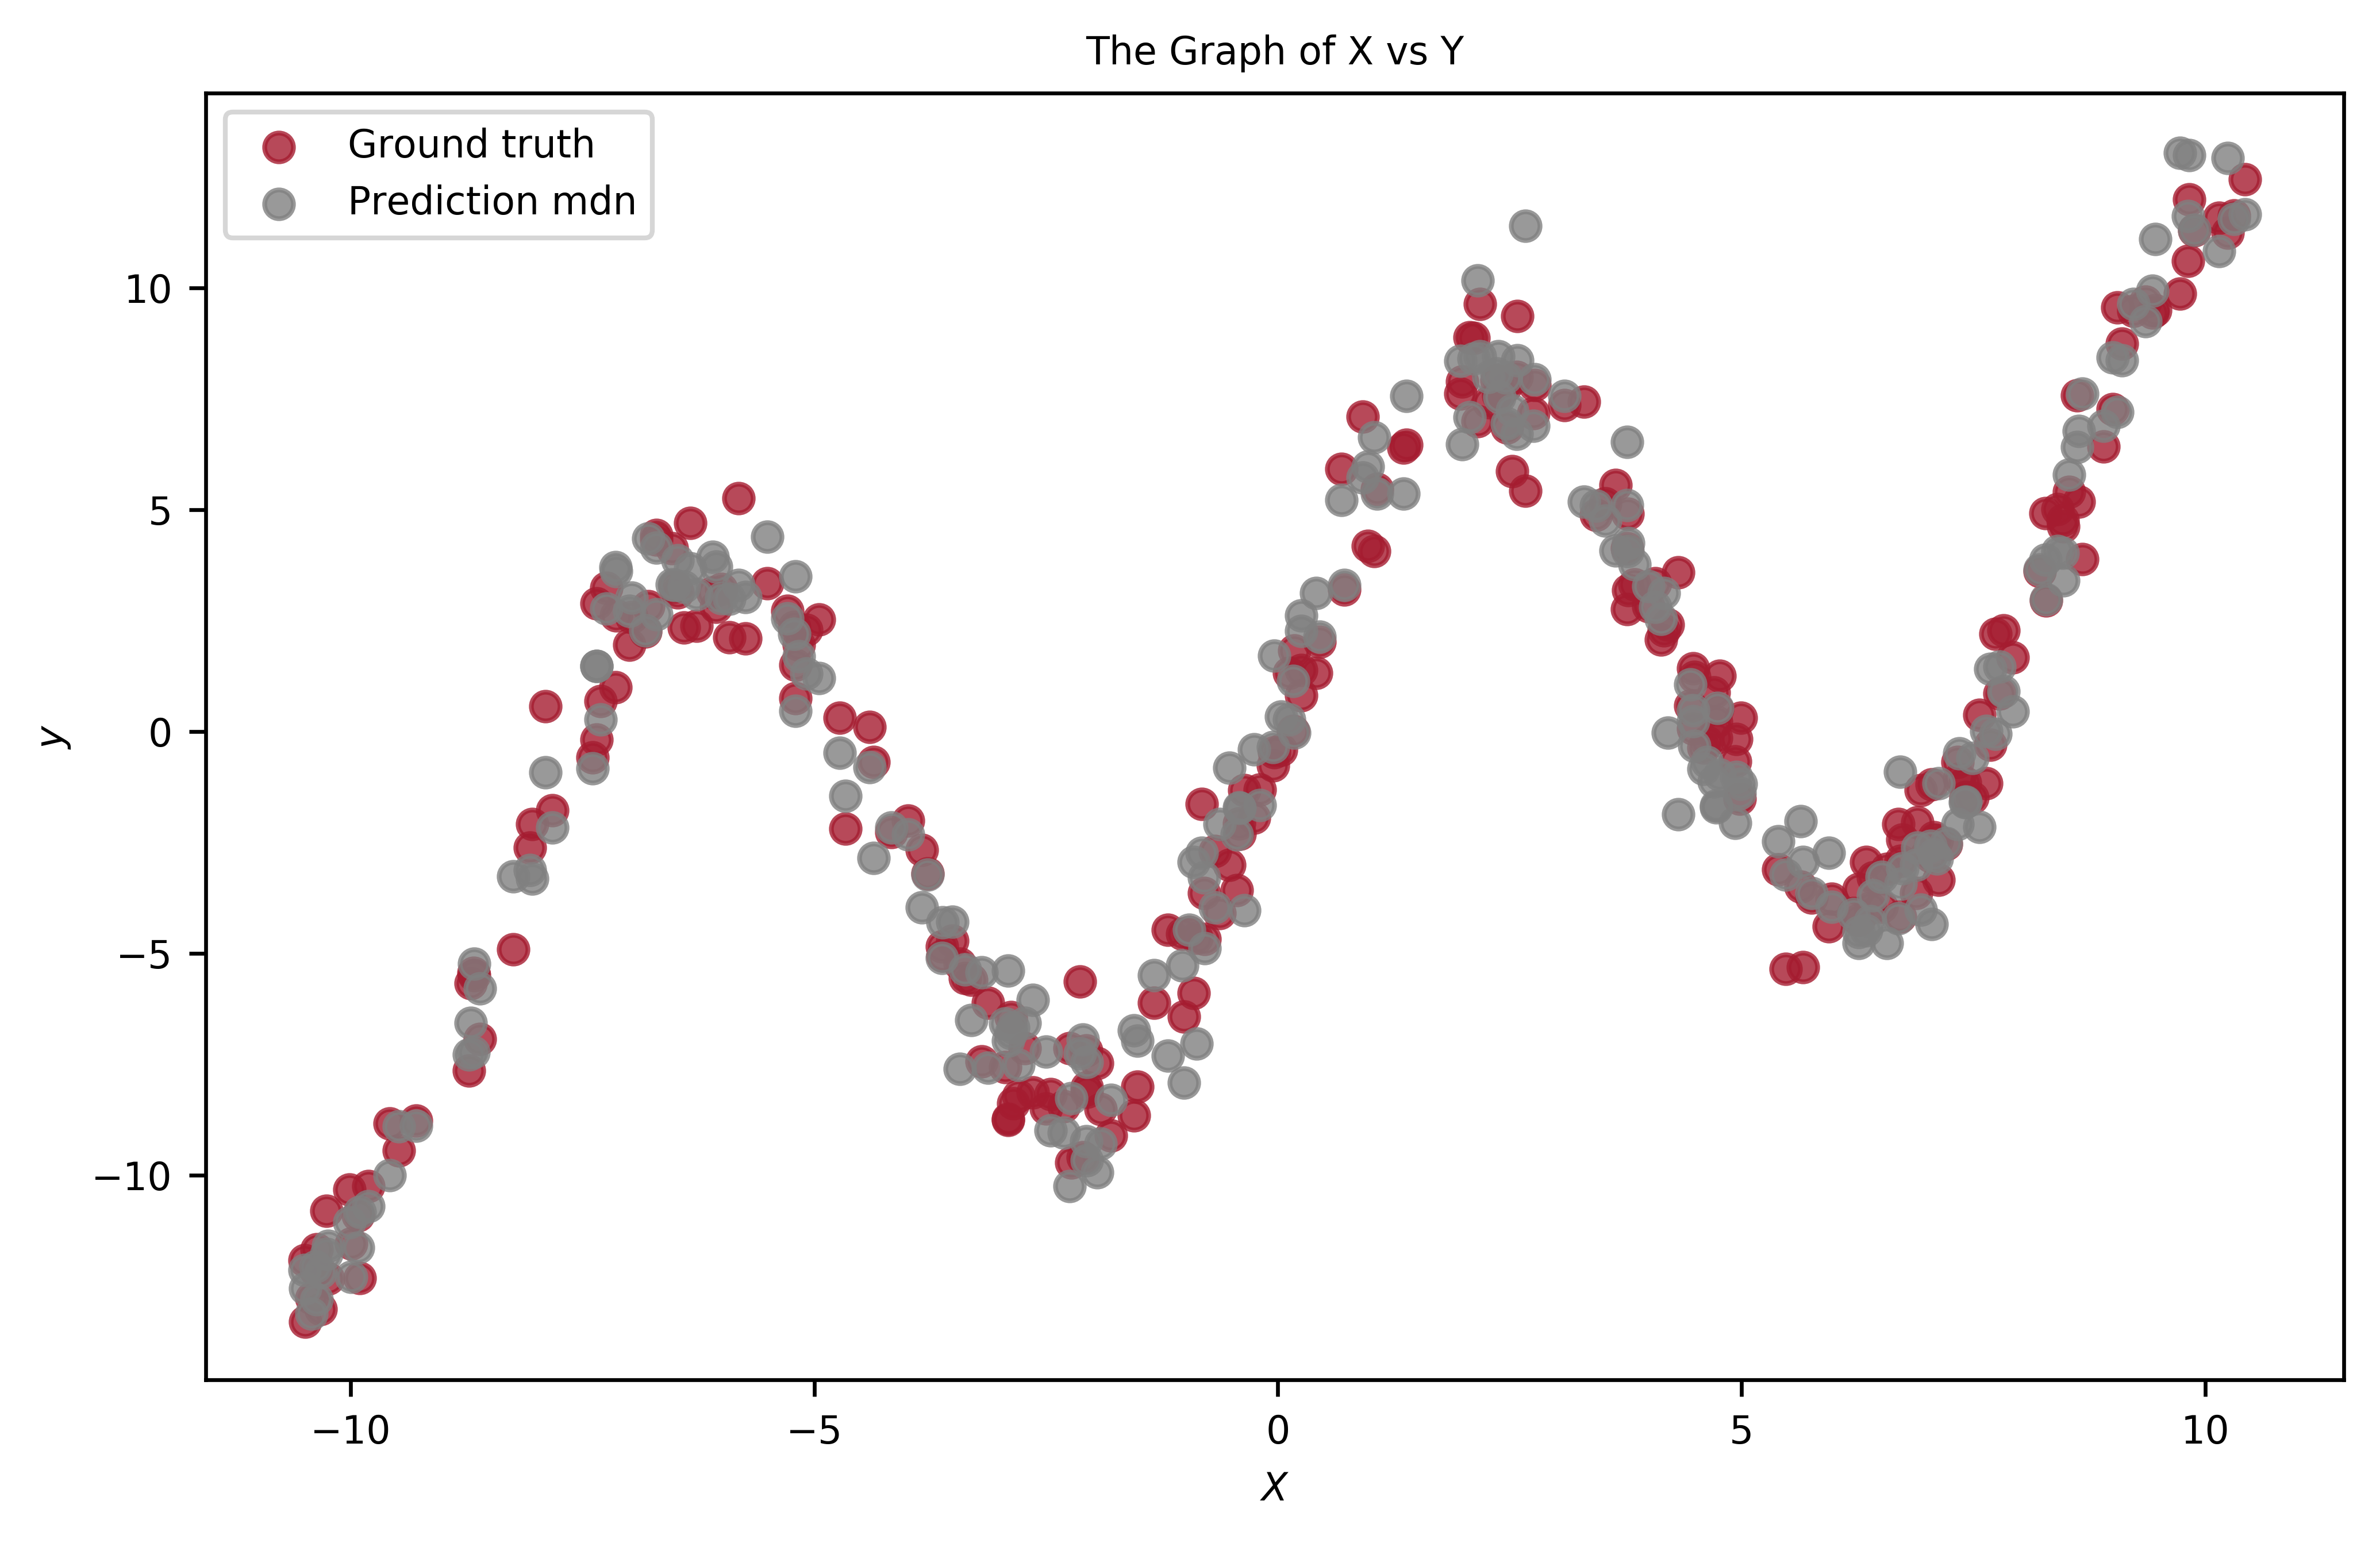

In [15]:
latexify(fig_width=8)
sns.regplot(X_test, y_test, fit_reg=False, label="Ground truth")
sns.regplot(X_test, y_pred_mdn, fit_reg=False, label="Prediction mdn")
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.legend()
plt.title("The Graph of X vs Y");

<div class="alert alert-block alert-info"> **Question:** Change the learning rate to 0.001, and rebuild theo model? comment on the results.

## Compare above results with DNN

In [31]:
class DNN(torch.nn.Module):

    def __init__(self, nb_input, hidden_size,  nb_output):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(DNN, self).__init__()
        
        self.l1 = torch.nn.Linear(nb_input, hidden_size)
        self.l2 = torch.nn.Linear(hidden_size, nb_output)
        self.tanh = torch.nn.Tanh()
       
        

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        out1 = self.l1(x)
        out2 = self.tanh(out1)
        y_pred = self.l2(out2)
        return y_pred

In [32]:
def model_train(x_data, y_data, model, lrate):
    
    x_data = torch.from_numpy(x_data).float()
    y_data = torch.from_numpy(y_data).float()
    
    x_data = Variable(x_data)
    y_data = Variable(y_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        y_data = y_data.cuda()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)
    criterion = torch.nn.MSELoss(size_average=False)
    
    
    
    Epoch = []
    Loss  = []
   
    
    for epoch in range(10000):
        y_pred = model(x_data)
        loss = criterion(y_pred, y_data)

        Epoch.append(epoch)
        Loss.append(loss.data[0])
        
        if (epoch % 500 == 0):
            print(epoch, loss.data[0])
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    return Epoch, Loss 

In [46]:
model_dnn = DNN(1, 50, 1)
print(model)

DNN(
  (l1): Linear(in_features=1, out_features=50)
  (l2): Linear(in_features=50, out_features=1)
  (tanh): Tanh()
)


In [47]:
epoch, loss = model_train(X_train, y_train, model_dnn, 0.01)

0 25857.69140625
500 696.9627685546875
1000 678.09423828125
1500 675.5686645507812
2000 674.545166015625
2500 672.9241333007812
3000 671.6427001953125
3500 670.5140380859375
4000 668.79345703125
4500 667.450439453125
5000 665.9357299804688
5500 663.812255859375
6000 661.2969970703125
6500 658.9205322265625
7000 656.1950073242188
7500 653.497802734375
8000 651.5762329101562
8500 650.451171875
9000 650.2792358398438
9500 648.0546875


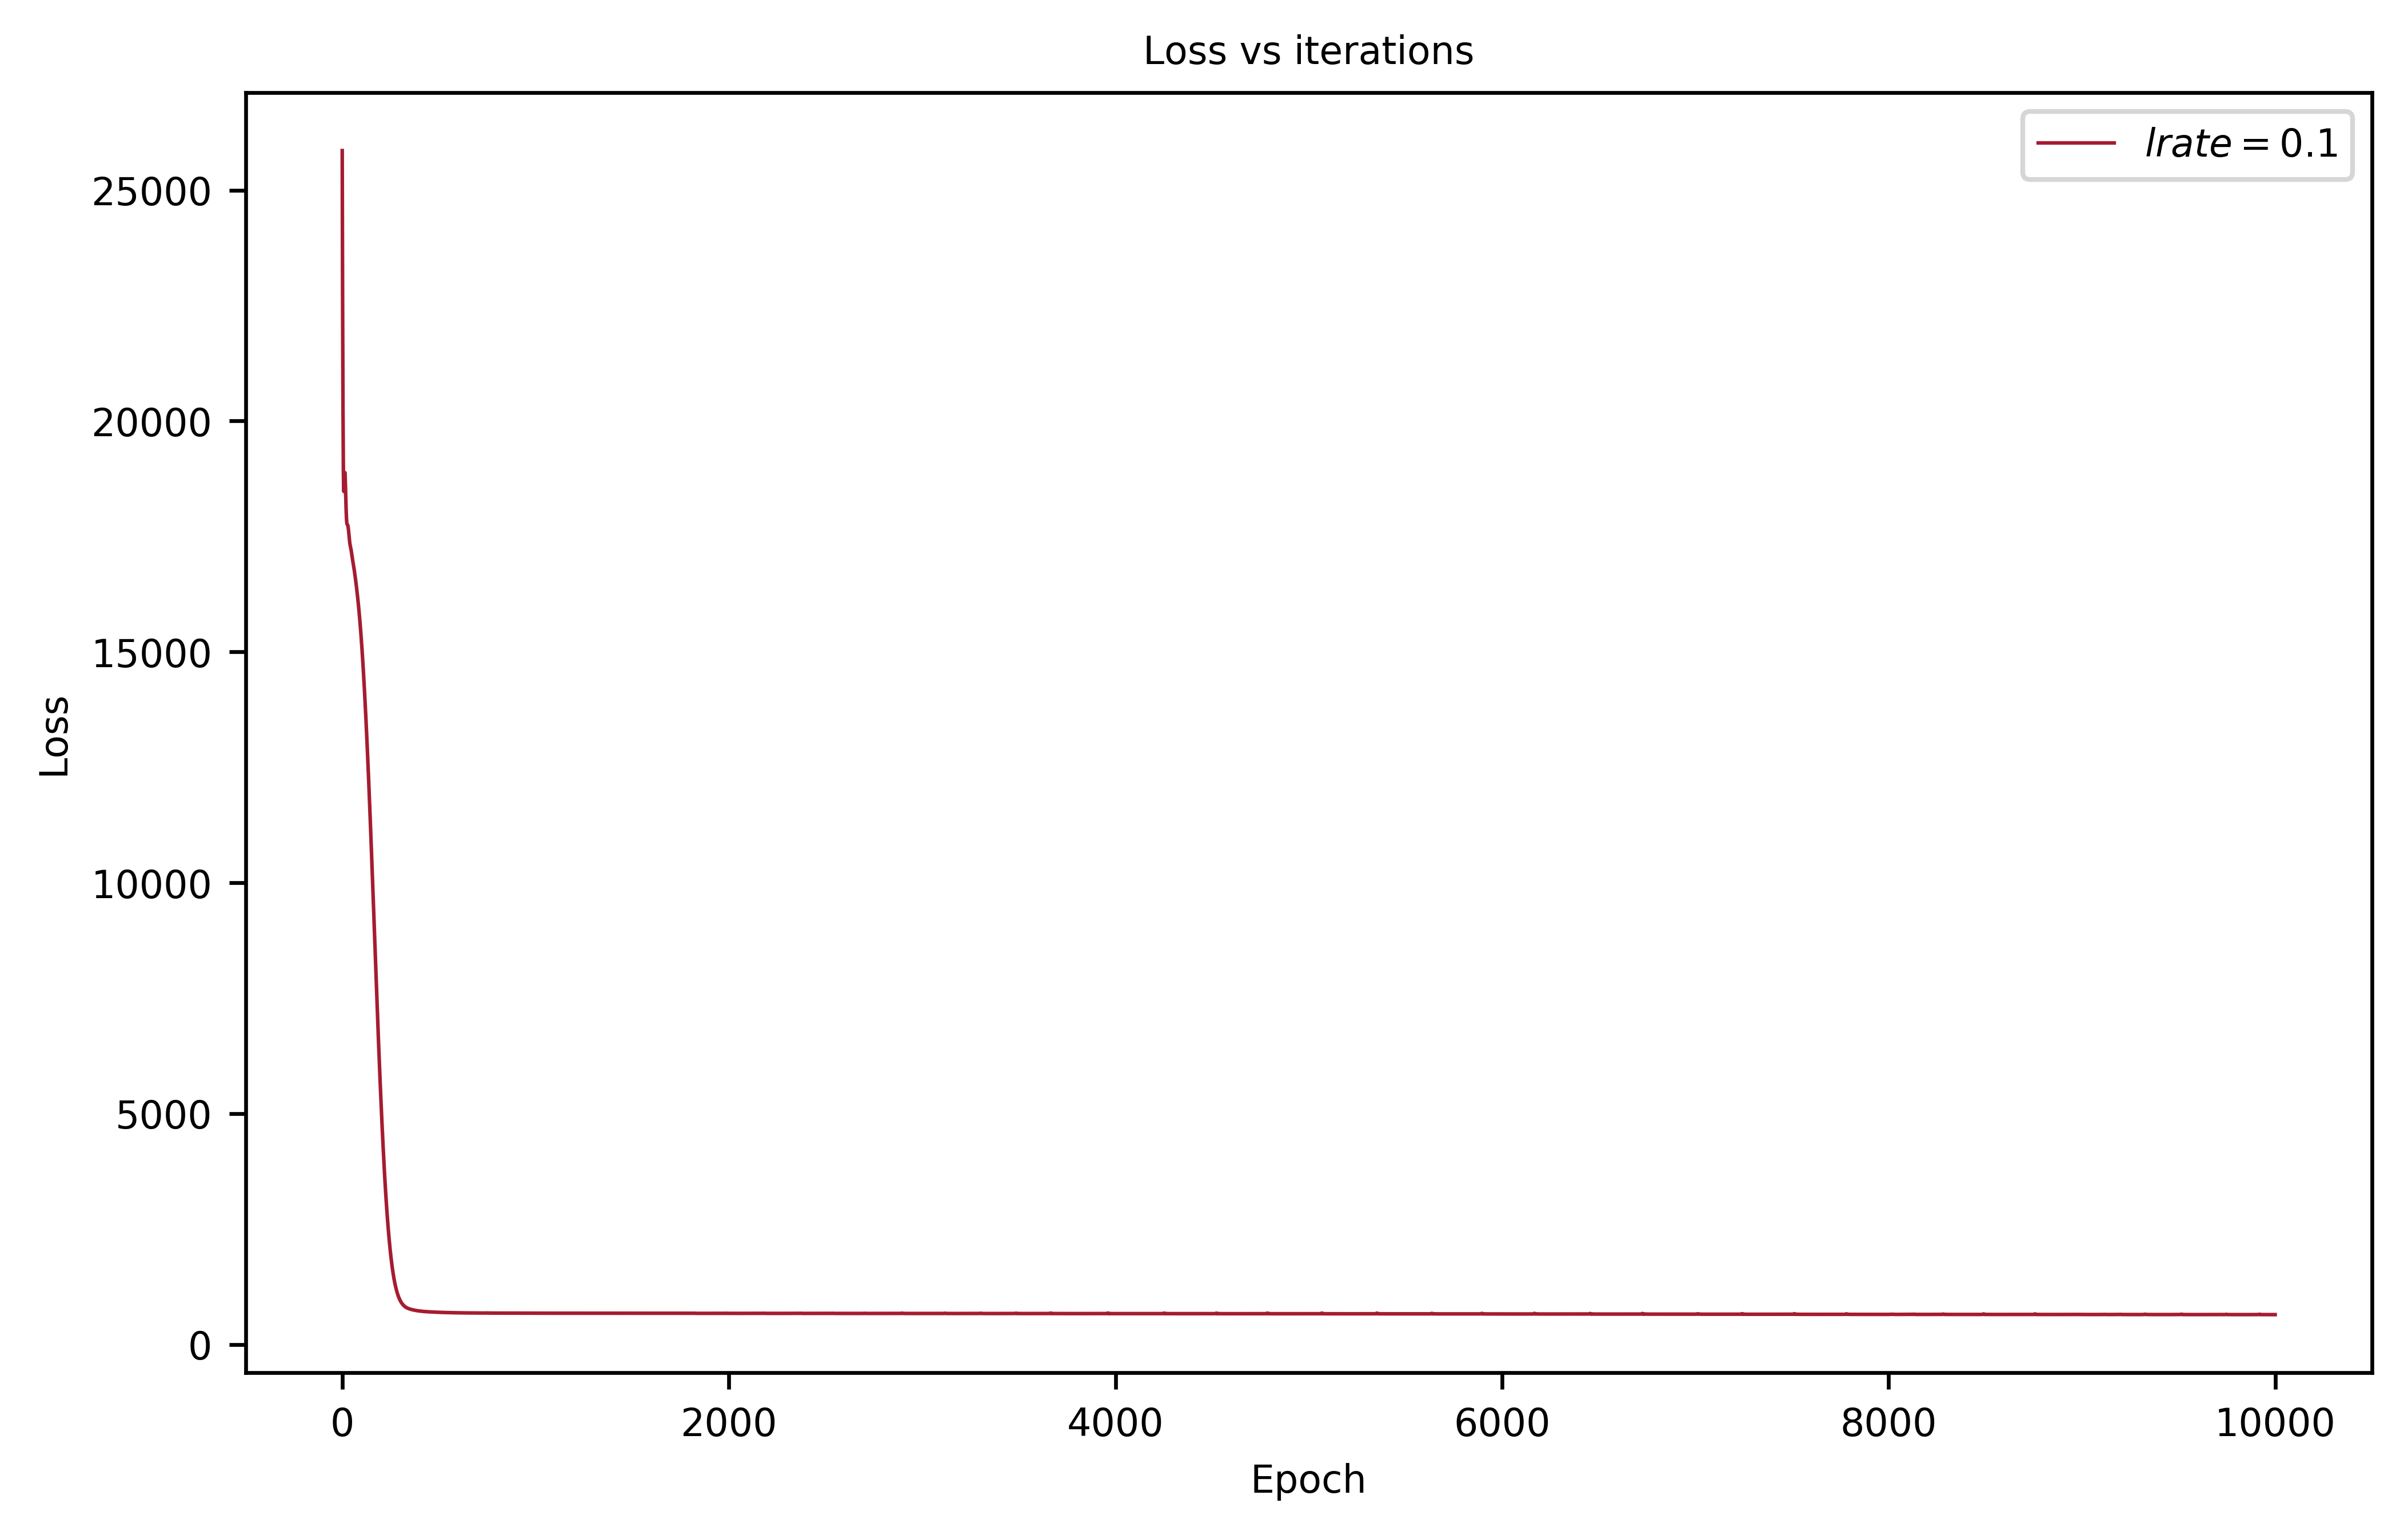

In [48]:
plt.plot(epoch, loss, label="$lrate=0.1$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs iterations")
plt.legend();

In [49]:
def predict_dnn(x_test, y_test, model):
    x_data = torch.from_numpy(x_test).float()
    x_data = Variable(x_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        
    y_pred = model(x_data)
    
    if torch.cuda.is_available():
        y_pred=y_pred.cpu() # convert cuda tenso into cpu so that we can con
        
    y_pred = y_pred.data.numpy()
    mse = MSE(y_test, y_pred)
    return y_pred, mse

In [50]:
y_pred_dnn, mse_dnn = predict_dnn(X_test, y_test, model_dnn)

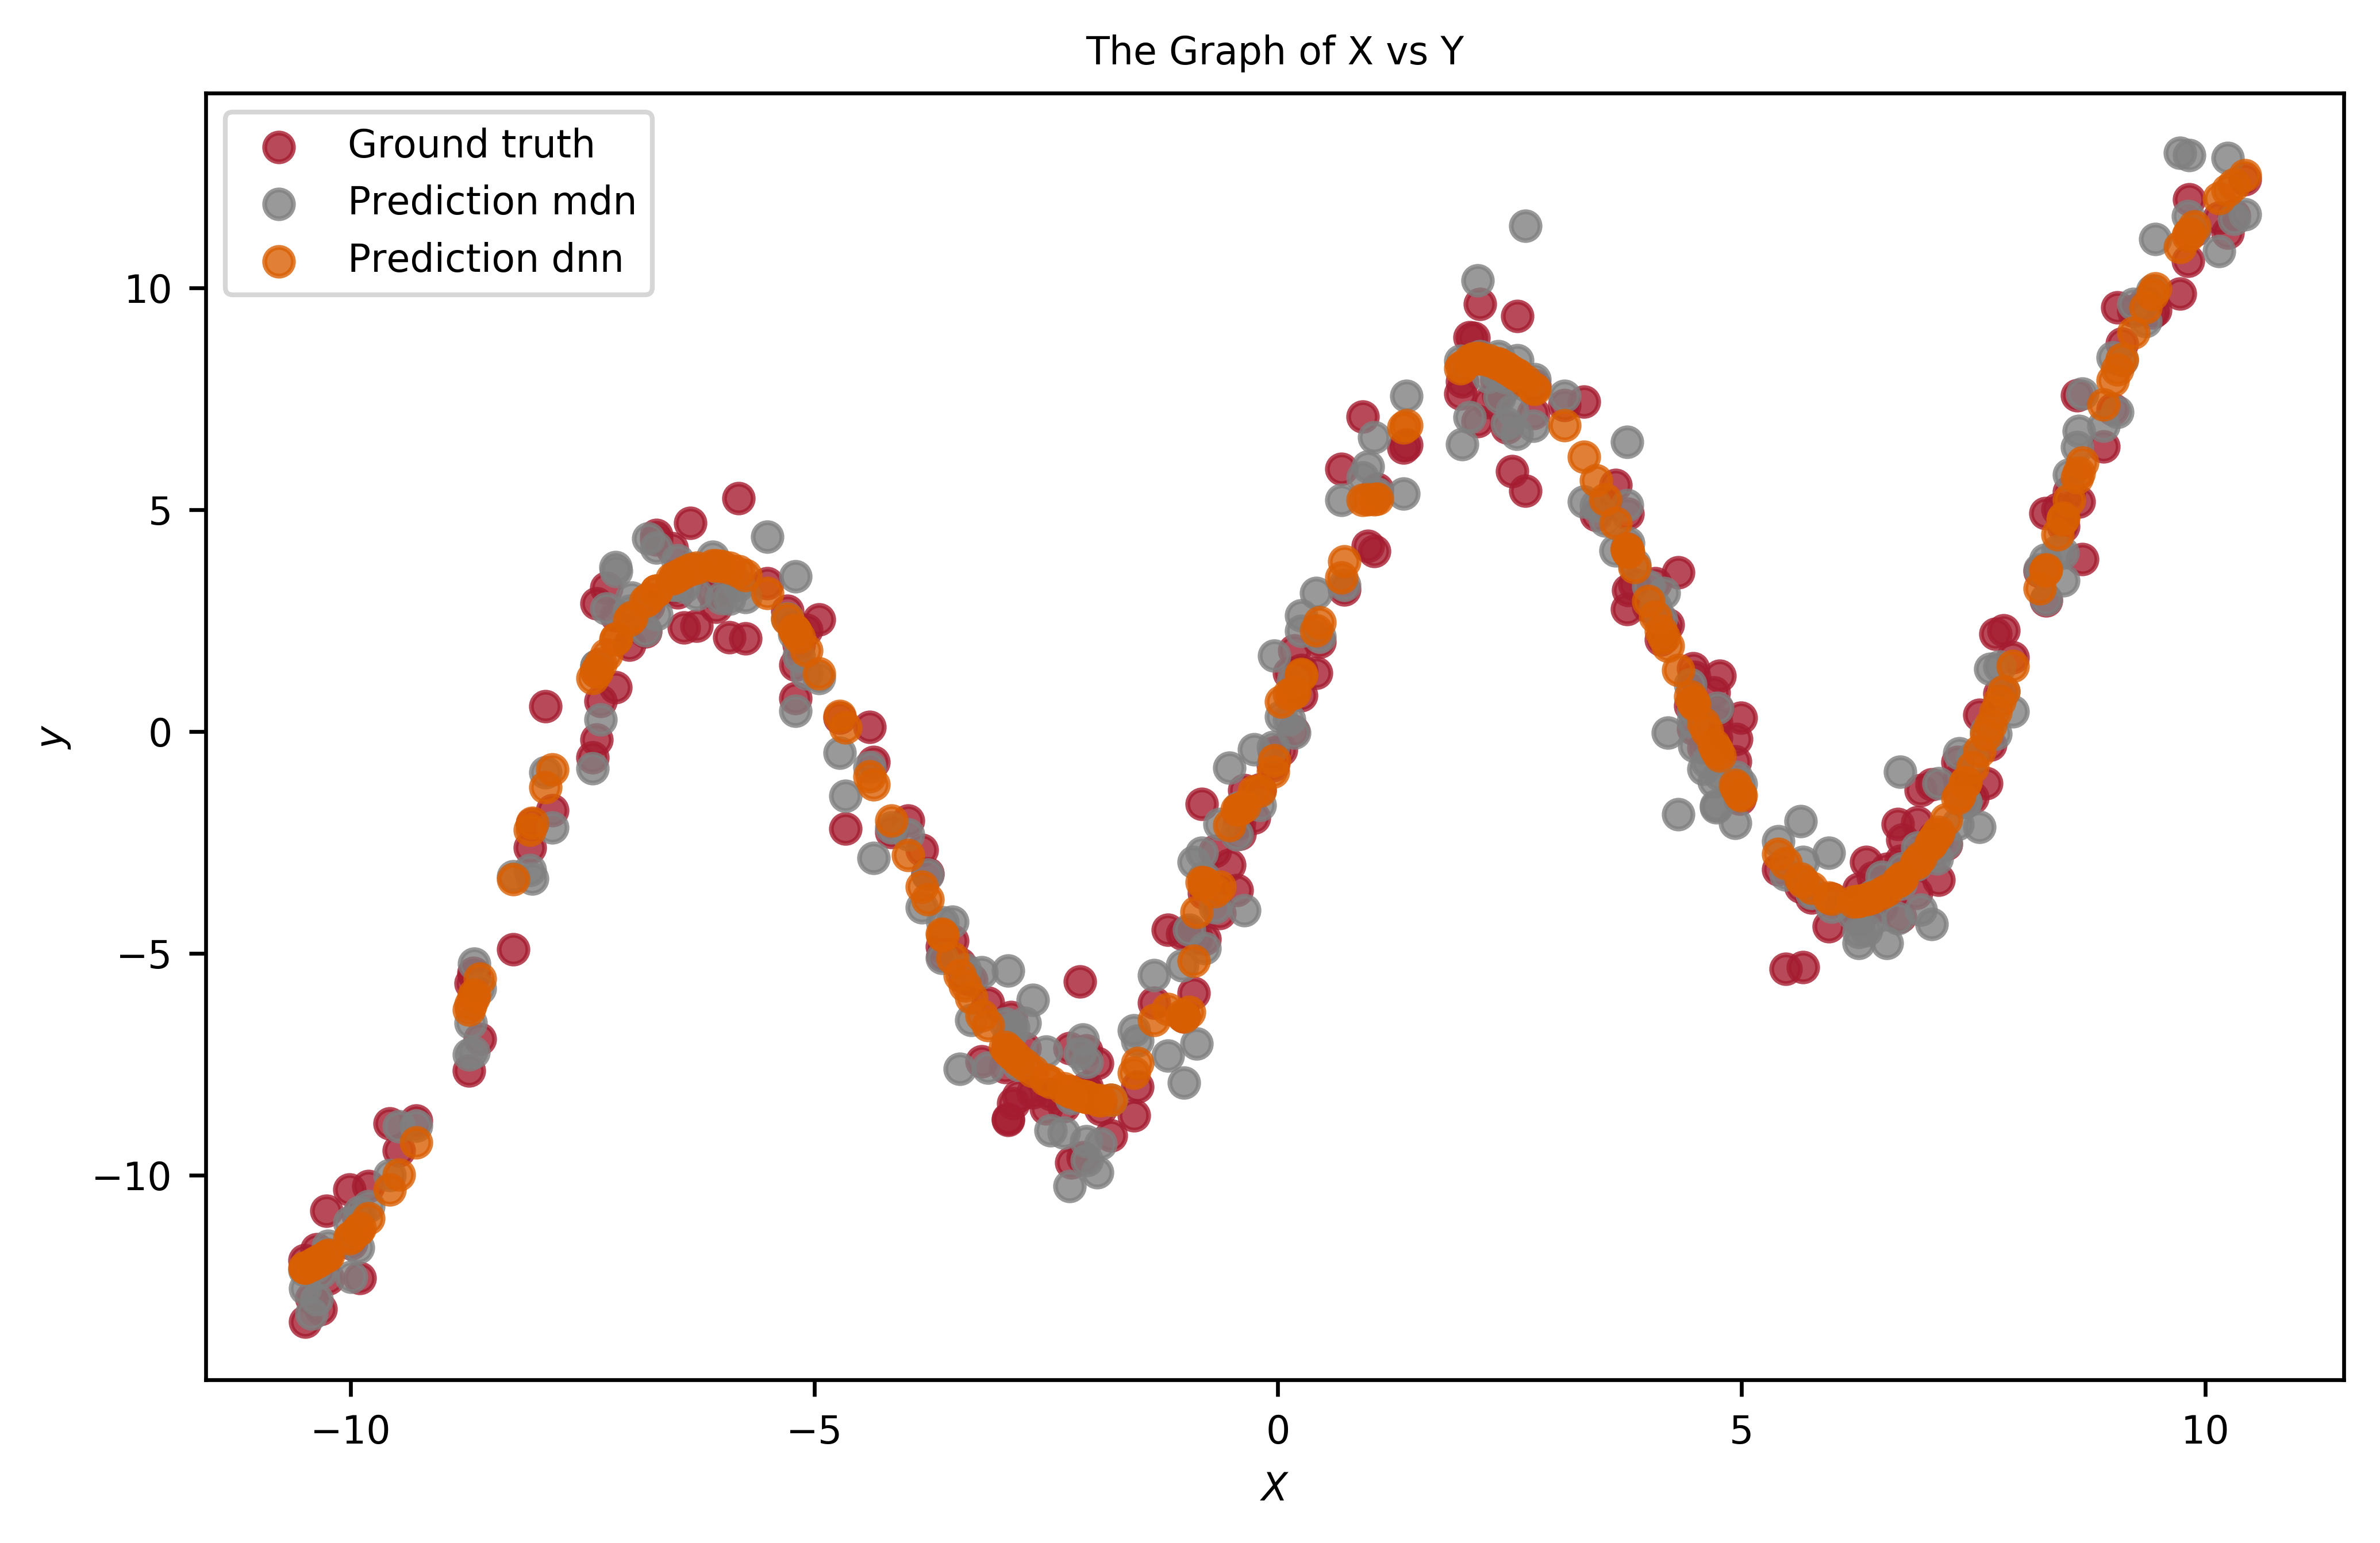

In [51]:
latexify(fig_width=8)
sns.regplot(X_test, y_test, fit_reg=False, label="Ground truth")
sns.regplot(X_test, y_pred_mdn, fit_reg=False, label="Prediction mdn")
sns.regplot(X_test, y_pred_dnn, fit_reg=False, label="Prediction dnn")
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.legend()
plt.title("The Graph of X vs Y");

([<matplotlib.axis.XTick at 0x7fc7f99ca908>,
 <a list of 2 Text xticklabel objects>)

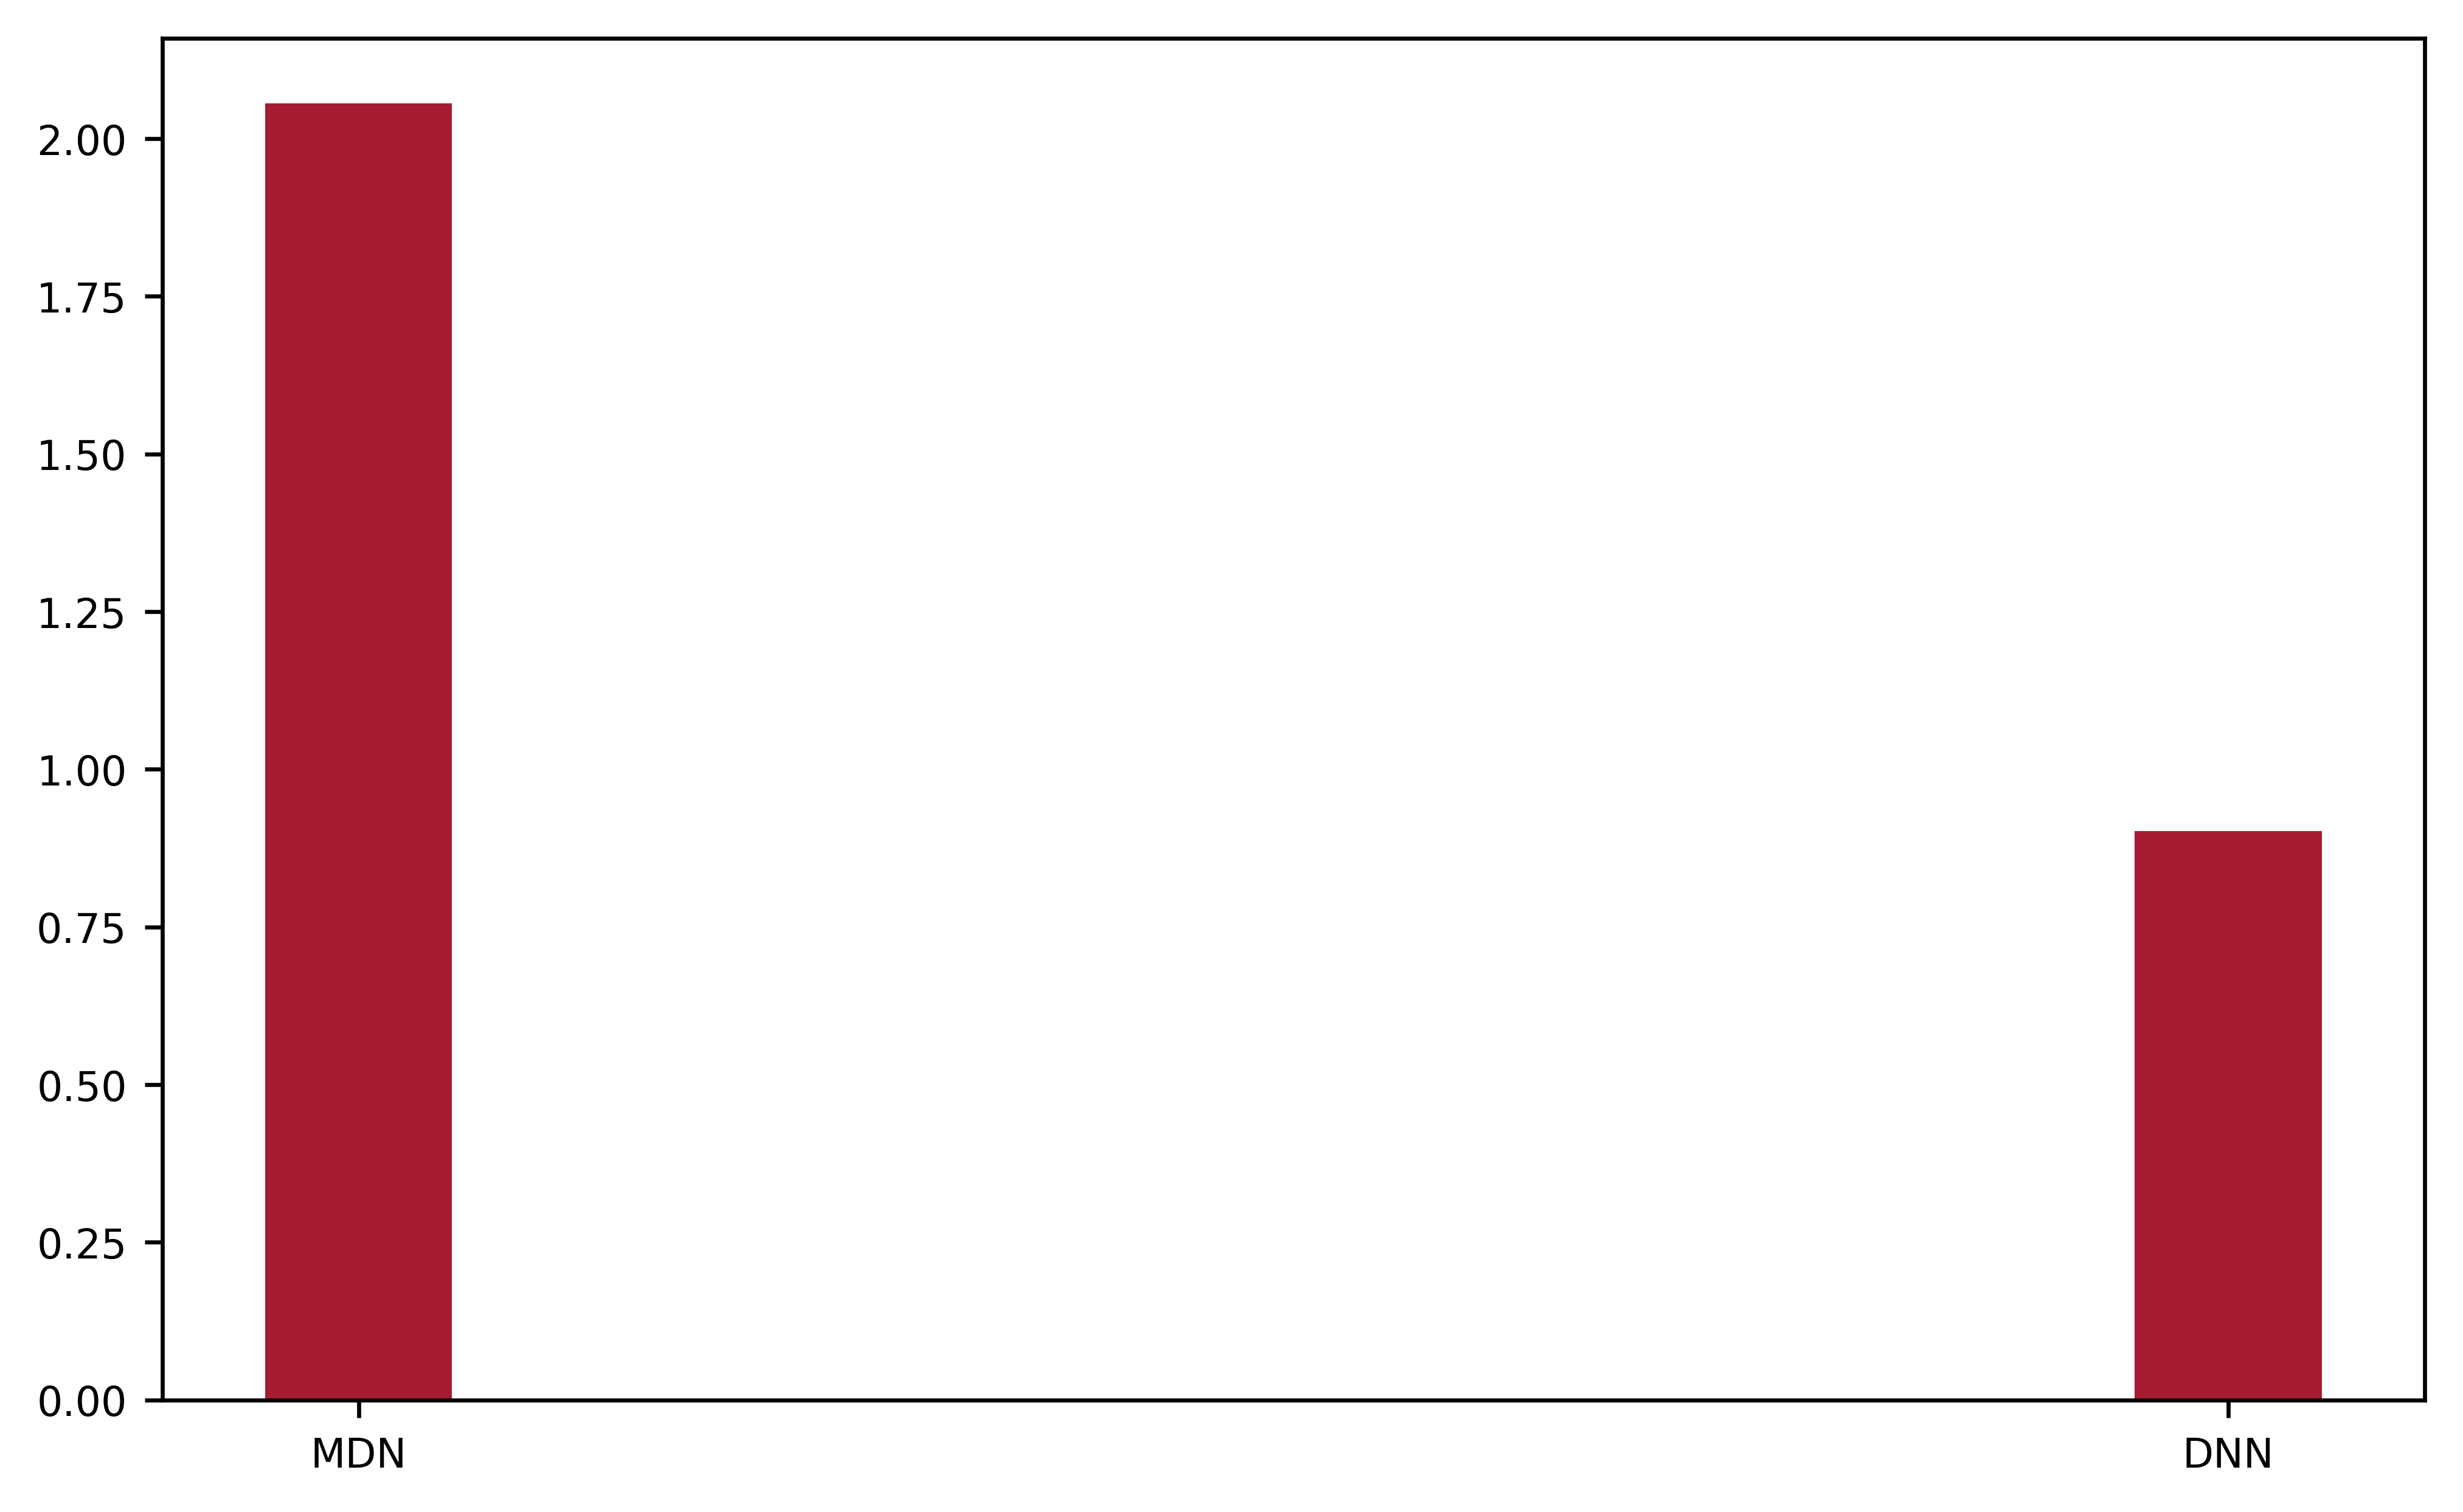

In [57]:
results = [mse_mdn, mse_dnn]
barwidth=0.1
plt.bar(np.arange(2),results, barwidth)
plt.xticks(np.arange(2),['MDN', 'DNN']);